# Exposed and Infected class calculations

This notebook implements methods to calculate exposed and infected classes based on death and confirmed case numbers

In [3]:
import pandas as pd
import numpy as np
from scipy.stats.distributions import gamma
import matplotlib.pyplot as plt


In [4]:
def normalize_jh_data(jh,name):
    jh['Country/Region'] = jh[['Country/Region','Province/State']].replace(np.nan,''""'').agg(' - '.join, axis=1).str.strip('- ')
    jh = jh.drop(columns=['Province/State','Lat','Long'])
    jh = jh.melt(id_vars=['Country/Region'],value_name=name)
    jh['variable'] = pd.to_datetime(jh['variable'])
    return jh

jhcc = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
jhd = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')


jhcc, jhd = normalize_jh_data(jhcc,'Confirmed'), normalize_jh_data(jhd,'Deaths')

out = jhd.set_index(['Country/Region','variable']).join(jhcc.set_index(['Country/Region','variable']))
out = out.loc[~out.index.duplicated()]

This is the infection to death distribution from the [ICL Paper](https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-30-COVID19-Report-13.pdf)

IFR is from [Wu et. al](https://www.nature.com/articles/s41591-020-0822-7) w/25% asymptomatic

In [5]:
ICL_STD = gamma(1/0.45**2,0,18.8*0.45**2)
ICL_ITS = gamma(1/0.86**2,0,5.1*0.86**2)

DEATHS_DAYS_S = np.array([ICL_STD.cdf(a+1)-ICL_STD.cdf(a) for a in range(100)])
S_DAYS = np.array([ICL_ITS.cdf(a+1)-ICL_ITS.cdf(a) for a in range(60)])

DEATHS_DAYS = np.convolve(DEATHS_DAYS_S,S_DAYS)

In [6]:
# see heading "Align Confirmed Cases" below

def transformCases(s,shift=-7):
    shifted = s.diff().shift(shift)
    return shifted


# This isn't very accurate, and a better nowcast might be useful.
# However, wherever we use it we then take a convolutions with a distributions with 
# very small weight on the relevant days, and it's probably not orders of magnitude out
# which an exponential fit can be

def fillforward(orig,fill=7, pred=7):
    s = orig.copy()
    data_x = np.linspace(1,pred,pred)
    data_pred = np.linspace(pred+1,pred+1+fill,fill)
    try:
        s[-fill:] = np.poly1d(np.polyfit(data_x,
                                       s[-(pred+fill):-fill],1))(data_pred)
    except ValueError:
        print('Invalid data for linear fit', s[-(pred+fill):-fill])
        # In this case, we really don't know what cases are likely to do
        s[-fill:] = np.nan
        return s
    return s

# see heading "Comparison of Expected Deaths" below


def expectedDeaths(s,fatality=0.008,shift=7):
    s_pad = np.pad(s,(len(DEATHS_DAYS)-2,0),constant_values=0)
    cv = np.convolve(fillforward(s_pad,fill=shift),DEATHS_DAYS,'valid')
    pw = len(s)-len(cv)
    return fatality*np.pad(cv,(pw,0),"constant",constant_values=np.nan)

## see heading "Recovered, Infectious and Exposed Classes" below


def lik_r(i,mu=0.5):
    return np.exp(-mu*i)

norm = lik_r(np.arange(1,100)).sum()

def r(i):
    return lik_r(i)/norm

def R(ti):
    ti_pad = np.pad(ti,(40,0),'constant',constant_values=0)
    cv = np.convolve(ti_pad,r(np.arange(1,42)),'valid')
    pw = len(ti)-len(cv)
    return np.pad(cv,(pw,0),"constant",constant_values=0)

norm_I = lik_r(np.arange(1,100),0.2).sum()

def inf(i):
    return lik_r(i,0.2)/norm_I

def E2I(new_exposed):
    ne_pad = np.pad(new_exposed,(40,0),'constant',constant_values=0)
    cv = np.convolve(ne_pad,inf(np.arange(1,42)),'valid')
    pw = len(new_exposed)-len(cv)
    return np.pad(cv,(pw,0),"constant",constant_values=0)

# Calculate ascertainment, true infection rates, exposed and infectious classes and add as new columns
# Returns a much smaller dataframe, as 

def filtered_mean(m,indices):
    return m[indices].mean()

def ascertainment(csse_ds,fatality = 0.008,shift=7):
    csse_df = csse_ds.copy()
    csse_df['New confirmed shifted'] = csse_df['Confirmed'].groupby(level=0).transform(transformCases,shift=-1*shift)
    csse_df['New deaths'] = csse_df['Deaths'].groupby(level=0).transform(lambda x: x.diff())
    
    g = csse_df.groupby(level=0)
    
    csse_df['Expected deaths'] = g['New confirmed shifted'].transform(expectedDeaths,fatality=fatality,shift=shift)
    
    deaths = csse_df['New deaths']>=10
    #last2 = csse_df.index.get_level_values(1)>= csse_df.index.get_level_values(1).max() - pd.Timedelta(days=14)
    
    indices = deaths# & last2
    
    csse_df['Ascertainment'] = np.nan
    
    csse_df.loc[indices,'Ascertainment'] = pd.to_numeric(csse_df.loc[indices,'Expected deaths']
                                            /csse_df.loc[indices,'New deaths'])
    
    csse_df['New cases true'] = (csse_df['New confirmed shifted']
                                             /csse_df.groupby(level=0)['Ascertainment'].transform(filtered_mean,indices))

    g2 = csse_df.groupby(level=0)
    ever_exposed = g2['New cases true'].transform(np.cumsum)
    new_post_exposed= g2['New cases true'].transform(lambda x: E2I(x))
    post_exposed = new_post_exposed.groupby(level=0).transform(np.cumsum)
    csse_df['Exposed'] = ever_exposed - post_exposed
    csse_df['Recovered'] = new_post_exposed.groupby(level=0).transform(lambda x: np.cumsum(R(x)))
    csse_df['Infectious'] = post_exposed - csse_df['Recovered']
    return csse_df

def window_sum(a, n=3) :
    ret = a.cumsum()
    ret2 = a.shift(n).cumsum()
    return (ret-ret2)/n

## Align confirmed cases

The first step is to calculate new infections timeshifted back by 7 days. The figure 7 comes from:
 - 5.5 days infection-to-symptoms (https://docs.google.com/spreadsheets/d/1yzVSp71jiCsoD_L6sXchfg8L9OF0tGHWEnCdfvF73Ac/edit#gid=1242721729)
 - 4 days symptoms-to-confirmation (also https://docs.google.com/spreadsheets/d/1yzVSp71jiCsoD_L6sXchfg8L9OF0tGHWEnCdfvF73Ac/edit#gid=1242721729)
 - Subtract two days as exponential growth means that fast confirmations will be overrepresented
 
We could in principle calculate this properly as we do with time to death, but for the purposes of calculating the true number of cases it is less crucial than calculating infection to death properly.

There may also be a lag in the reporting of deaths. However, adding a lag produces unreasonable results, which may indicate that the above lag of 7 is too short.

In [7]:
csse_demo = out.copy()

csse_demo['New Confirmed Shifted'] = csse_demo['Confirmed'].groupby(level=0).transform(transformCases,shift=-7)
csse_demo['New Deaths'] = csse_demo['Deaths'].groupby(level=0).transform(transformCases,shift=-0)

csse_demo.loc['Italy'][-10:]

,Deaths,Confirmed,New Confirmed Shifted,New Deaths
variable,,,,
2020-04-12,19899,156363,3047.0,431.0
2020-04-13,20465,159516,2256.0,566.0
2020-04-14,21067,162488,2729.0,602.0
2020-04-15,21645,165155,NaN,578.0
2020-04-16,22170,168941,NaN,525.0
2020-04-17,22745,172434,NaN,575.0
2020-04-18,23227,175925,NaN,482.0
2020-04-19,23660,178972,NaN,433.0
2020-04-20,24114,181228,NaN,454.0


## Comparison of Expected Deaths

The number of deaths on day $i$ should be
$$ d_i = f \sum_j p_{i-j} t_j $$
where $f$ is the infection fatality rate, $p_k$ is the probability of dieing $k$ days after being infected and $t_j$ is the true number of cases on day $j$.

Suppose that there is a fixed ascertainment rate $a$ such that confirmed cases $c_j=a t_{j-7}$ for all $j$. Then 

$$ a = \frac{f\sum_j p_{i-j} c_{j+7}}{d_{i}} $$

**Note** This is actually *lagged* ascertainment rate - it asks "what fraction of new cases today are detected 7 days later". I don't directly estimate an instantaneous ascertainment rate as this is very sensitive to the short term trajectory of infections, which, as I note above, I can't yet forecast. What we can in fact calculate is:

$$ t_{i-7} = \frac{c_i}{a}  $$

In [8]:
g = csse_demo.groupby(level=0)

csse_demo['Expdeaths'] = g['New Confirmed Shifted'].transform(expectedDeaths,fatality=0.008)
csse_demo['Ascertainment'] = csse_demo['Expdeaths']/csse_demo['New Deaths']

To compare this to [ICL Report 13](https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-30-COVID19-Report-13.pdf), we take the average ascertainment estimate for the UK

In [10]:
csse_demo.loc['United Kingdom','Ascertainment'][-20:].mean()

0.02777469921686304

Given the lag we include, the number of cases in existence on March 28th is the number of cases detected on April 4th. The ICL report also uses an IFR of around 1 vs the 0.8 we used to calculate this table. So, estimated percentage who have ever been infected as of March 28th is
$$\text{Cumulative infections} = \frac{IFR_{ICL}}{IFR_{nb}}\cdot\frac{\text{confirmed cases on April 4th}}{\text{Average ascertainment}}\cdot\frac{1}{\text{UK population}}$$

In [11]:
1./0.8*41903/0.0278/66e6

0.028547389361238282

This is rather similar to their central estimate of 2.7% infected, which is probably to be expected given that we use their infection-to-death distribution

This method suggests that ascertainment in Italy has been rising substantially. In fact, I suspect this indicates I haven't calibrated the timings properly.

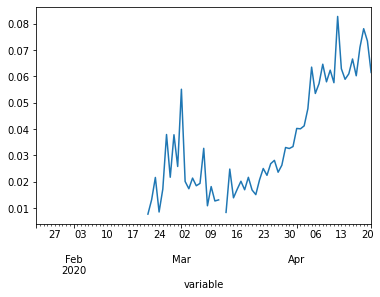

In [12]:
csse_demo.loc['Italy','Ascertainment'].plot()

Ascertainment in Brazil looks to be gradually rising.

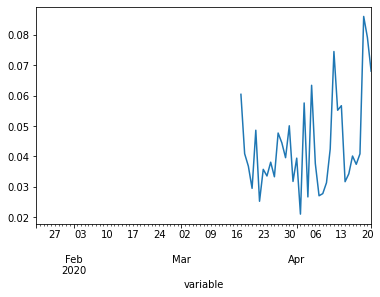

In [13]:
csse_demo.loc['Brazil','Ascertainment'].replace(np.inf,np.nan).plot()

Ascertainment in Sweden does not look to be rising

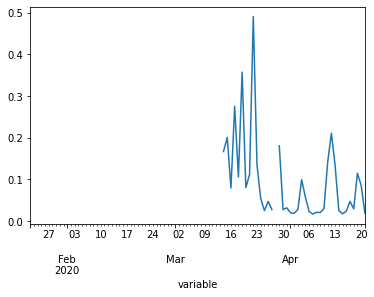

In [14]:
csse_demo.loc['Sweden','Ascertainment'].plot()

# Filter out small numbers of deaths

The method doesn't work well with small numbers of deaths per day. Fully Bayesian treatment probably handles this case better, or even variance weighted averaging. However, for now I just remove days with small numbers of new deaths from consideration.

## Recovered, Infectious and Exposed Classes

The infectious class is given by 

$$ I_i = \sum_{j} q_{i-j} t_j - \sum_{j} r_{i-j} t_j $$

and the exposed class by 

$$ E_i = \sum_j (1-q_{i-j}) t_j $$

finally, the recovered class is given by

$$ R_i = \sum_j r_{i-j} t_j $$

Where $q_n$ is the distribution of the time from being exposed to being infectious, $E_i$ and $I_i$ the size of the exposed and infected classes on day $i$ and $t_j$ the true number of new cases on day $j$ as above

To make the infectious class match [GLEAM's treatment](http://www.gleamviz.org/simulator/models/), we take $q_{i-j}=A e^{-(i-j)\epsilon}$ where $A$ is some normalising constant. That is, the transition probability is an exponential. Currently we use $\epsilon=0.2$.

To get a recovery rate that matches our use of GLEAM, we could take $r_i = B e^{-i\mu}$ where $\mu=0.5$ is the rate of recovery from GLEAM and $B$ is a normalising constant. This is a bit unrealistic, but alternative approaches are tricky to implement.

Another possibility is to take the "serial interval" distribution from https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-30-COVID19-Report-13.pdf (note that this seems to be the distribution of probability of infection, not probability of first infection, so it's not acutally the serial interval). However, we need to turn this nonexponential distribution into an exponential infectious class, and figuring out how to approximate this appropriately seems hard.

In [15]:
# Just calculate everything


low = ascertainment(out,0.003,shift=7)
mid = ascertainment(out,0.008,shift=7)
high = ascertainment(out,0.015,shift=7)

In [16]:
mid.loc['Sweden'][-20:]

,Deaths,Confirmed,New confirmed shifted,New deaths,Expected deaths,Ascertainment,New cases true,Exposed,Recovered,Infectious
variable,,,,,,,,,,
2020-04-02,308,5568,722.0,69.0,1.264882,0.018332,14061.490809,44953.891820,119386.220852,13687.709323
2020-04-03,358,6131,544.0,50.0,1.373044,0.027461,10594.807479,45479.439959,128733.859639,14409.329876
2020-04-04,373,6443,466.0,15.0,1.487282,0.099152,9075.699054,44665.983533,138294.568642,14737.776353
2020-04-05,401,6830,332.0,28.0,1.607179,0.057399,6465.948682,41863.299820,147740.354455,14560.622935
2020-04-06,477,7206,465.0,76.0,1.732248,0.022793,9056.223305,41689.399779,157101.283699,14429.817037
2020-04-07,591,7693,497.0,114.0,1.861721,0.016331,9679.447274,42057.288668,166442.787024,14399.872098
2020-04-08,687,8419,482.0,96.0,1.994467,0.020776,9387.311038,42119.366898,175777.888399,14390.003531
2020-04-09,793,9141,613.0,106.0,2.129045,0.020085,11938.634163,44259.045739,185295.502080,14671.345171
2020-04-10,870,9685,676.0,77.0,2.263856,0.029401,13165.606353,47015.484644,195163.914834,15212.099865
